# Tutorial part 2 Word Vectors

## Gensim

* [gensim: models.word2vec – Deep learning with word2vec](https://radimrehurek.com/gensim/models/word2vec.html)
* [한국어와 NLTK, Gensim의 만남 - PyCon Korea 2015](https://www.lucypark.kr/docs/2015-pyconkr/)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

train = pd.read_csv('data/labeledTrainData.tsv', header=0, delimiter='\t', quoting=3)
test = pd.read_csv('data/testData.tsv', header=0, delimiter='\t', quoting=3)
unlabeled_train = pd.read_csv('data/unlabeledTrainData.tsv', header=0, delimiter='\t', quoting=3)

print(train.shape)
print(test.shape)
print(unlabeled_train.shape)

print(train['review'].size)
print(test['review'].size)
print(unlabeled_train['review'].size)

(25000, 3)
(25000, 2)
(50000, 2)
25000
25000
50000


In [3]:
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords

def review_to_wordlist(review, remove_stopwords=False):
    # 1. HTML 제거
    review_text = BeautifulSoup(review, "html.parser").get_text()
    # 2. 특수문자를 공백으로 바꿔줌
    review_text = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. 소문자로 변환 후 나눈다.
    words = review_text.lower().split()
    # 4. 불용어 제거
    if remove_stopwords:
        stops = set(stopwords.words('english'))
        words = [w for w in words if not w in stops]
    # 5. Return a list of words
    return(words)

In [4]:
# punkt tokenizer 를 다운로드 받아 사용한다.
import nltk.data

def review_to_sentences( review, remove_stopwords=False ):
    # punkt tokenizer를 로드한다.
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    # 1. nltk tokenizer를 사용해서 단어로 토큰화 하고 공백 등을 제거한다.
    raw_sentences = tokenizer.tokenize(review.strip())
    # 2. 각 문장을 순회한다.
    sentences = []
    for raw_sentence in raw_sentences:
        # 비어있다면 skip
        if len(raw_sentence) > 0:
            # 태그제거, 알파벳문자가 아닌 것은 공백으로 치환, 불용어제거
            sentences.append(review_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

In [5]:
review = train['review'][0]
remove_stopwords=False
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

raw_sentences = tokenizer.tokenize(review.strip())
# 2. 각 문장을 순회한다.
sentences = []
for raw_sentence in raw_sentences:
    # 비어있다면 skip
    if len(raw_sentence) > 0:
        sentences.append(review_to_wordlist(raw_sentence, remove_stopwords))

In [6]:
# sentences를 초기화 해준다.
sentences = []

# for review in train['review']:
#     sentences += review_to_sentences(review)
    
%time train["sentences"] = train["review"].apply(review_to_sentences)

CPU times: user 41 s, sys: 2.93 s, total: 43.9 s
Wall time: 44.5 s


In [7]:
for review in unlabeled_train['review']:
    sentences += review_to_sentences(review, tokenizer)

In [8]:
len(sentences)

528987

In [9]:
sentences[0]

['watching', 'time', 'chasers', 'obvious', 'made', 'bunch', 'friends']

### 모델을 학습시킨다.

In [10]:
import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [11]:
# 파라메터값 지정
num_features = 300 # 문자 벡터 차원 수
min_word_count = 40 # 최소 문자 수
num_workers = 4 # 병렬 처리 스레드 수
context = 10 # 문자열 창 크기
downsampling = 1e-3 # 문자 빈도 수 Downsample

# 초기화 및 모델 학습
from gensim.models import word2vec

# 모델 학습
model = word2vec.Word2Vec(sentences, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling)
model

2018-01-01 16:12:17,888 : INFO : 'pattern' package not found; tag filters are not available for English
2018-01-01 16:12:17,894 : INFO : collecting all words and their counts
2018-01-01 16:12:17,895 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-01-01 16:12:17,926 : INFO : PROGRESS: at sentence #10000, processed 115423 words, keeping 17233 word types
2018-01-01 16:12:17,957 : INFO : PROGRESS: at sentence #20000, processed 227635 words, keeping 24591 word types
2018-01-01 16:12:17,987 : INFO : PROGRESS: at sentence #30000, processed 341925 words, keeping 29834 word types
2018-01-01 16:12:18,019 : INFO : PROGRESS: at sentence #40000, processed 456188 words, keeping 34015 word types
2018-01-01 16:12:18,048 : INFO : PROGRESS: at sentence #50000, processed 568057 words, keeping 37586 word types
2018-01-01 16:12:18,079 : INFO : PROGRESS: at sentence #60000, processed 683038 words, keeping 40853 word types
2018-01-01 16:12:18,112 : INFO : PROGRESS: at sentence

2018-01-01 16:12:31,322 : INFO : PROGRESS: at 24.21% examples, 572362 words/s, in_qsize 8, out_qsize 1
2018-01-01 16:12:32,328 : INFO : PROGRESS: at 26.44% examples, 573385 words/s, in_qsize 7, out_qsize 0
2018-01-01 16:12:33,329 : INFO : PROGRESS: at 28.32% examples, 567716 words/s, in_qsize 7, out_qsize 0
2018-01-01 16:12:34,355 : INFO : PROGRESS: at 29.72% examples, 552658 words/s, in_qsize 8, out_qsize 0
2018-01-01 16:12:35,358 : INFO : PROGRESS: at 31.52% examples, 547387 words/s, in_qsize 8, out_qsize 0
2018-01-01 16:12:36,362 : INFO : PROGRESS: at 33.25% examples, 541622 words/s, in_qsize 7, out_qsize 0
2018-01-01 16:12:37,366 : INFO : PROGRESS: at 35.23% examples, 540153 words/s, in_qsize 7, out_qsize 0
2018-01-01 16:12:38,380 : INFO : PROGRESS: at 36.85% examples, 533706 words/s, in_qsize 8, out_qsize 0
2018-01-01 16:12:39,450 : INFO : PROGRESS: at 38.40% examples, 525062 words/s, in_qsize 8, out_qsize 0
2018-01-01 16:12:40,452 : INFO : PROGRESS: at 39.59% examples, 514734 wor

In [12]:
model.init_sims(replace=True)

model_name = '300features_40minwords_10text'
model.save(model_name)

2018-01-01 16:13:16,891 : INFO : precomputing L2-norms of word weight vectors
2018-01-01 16:13:17,073 : INFO : saving Word2Vec object under 300features_40minwords_10text, separately None
2018-01-01 16:13:17,074 : INFO : not storing attribute syn0norm
2018-01-01 16:13:17,075 : INFO : not storing attribute cum_table
2018-01-01 16:13:17,423 : INFO : saved 300features_40minwords_10text


## 모델 결과 탐색 
Exploring the Model Results

In [13]:
model.wv.doesnt_match('man woman child kitchen'.split())

'kitchen'

In [14]:
model.wv.doesnt_match("france england germany berlin".split())

'berlin'

In [15]:
model.wv.most_similar("man")

[('lady', 0.5934991836547852),
 ('woman', 0.5787922739982605),
 ('men', 0.5405680537223816),
 ('person', 0.4665006101131439),
 ('lad', 0.4446686804294586),
 ('chap', 0.44292932748794556),
 ('grandson', 0.4405399560928345),
 ('mans', 0.4382113516330719),
 ('reggie', 0.4352819621562958),
 ('hides', 0.41569000482559204)]

In [16]:
model.wv.most_similar("queen")

[('princess', 0.6648011803627014),
 ('belle', 0.6518158912658691),
 ('goddess', 0.6383790969848633),
 ('isabel', 0.6343656182289124),
 ('eva', 0.6254183053970337),
 ('virginal', 0.6192551851272583),
 ('mama', 0.6187054514884949),
 ('nina', 0.6159491539001465),
 ('englishman', 0.608016848564148),
 ('marian', 0.606728732585907)]

In [17]:
model.wv.most_similar("awful")

[('terrible', 0.8213358521461487),
 ('horrible', 0.7845640182495117),
 ('horrid', 0.7520546317100525),
 ('abysmal', 0.7511774301528931),
 ('atrocious', 0.7464680075645447),
 ('dreadful', 0.734341025352478),
 ('appalling', 0.7171346545219421),
 ('horrendous', 0.7165898680686951),
 ('lousy', 0.6959255337715149),
 ('crappy', 0.6539549231529236)]

In [18]:
model.wv.most_similar("movie")

[('film', 0.7078158855438232),
 ('movies', 0.6191653609275818),
 ('flick', 0.5997164845466614),
 ('thats', 0.4400213956832886),
 ('guess', 0.43591421842575073),
 ('sequel', 0.42672285437583923),
 ('anime', 0.42370304465293884),
 ('think', 0.4213681221008301),
 ('really', 0.41766291856765747),
 ('sure', 0.4098387658596039)]

In [19]:
model.wv.most_similar("happy")

[('happier', 0.4952372610569),
 ('sad', 0.49197983741760254),
 ('cry', 0.4850948750972748),
 ('gilmore', 0.448981374502182),
 ('satisfied', 0.4470290243625641),
 ('wanting', 0.4366462826728821),
 ('happiness', 0.4328655004501343),
 ('lucky', 0.42897799611091614),
 ('optimistic', 0.4267984628677368),
 ('proud', 0.41858604550361633)]

In [20]:
# 참고 https://stackoverflow.com/questions/43776572/visualise-word2vec-generated-from-gensim
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

model_name = '300features_40minwords_10text'
model = g.Doc2Vec.load(model_name)

vocab = list(model.wv.vocab)
X = model[vocab]

print(len(X))
# print(X[0])
tsne = TSNE(n_components=2)

X_tsne = tsne.fit_transform(X[:100,:])
# X_tsne = tsne.fit_transform(X)

2018-01-01 16:13:17,865 : INFO : loading Doc2Vec object from 300features_40minwords_10text
2018-01-01 16:13:18,108 : INFO : loading wv recursively from 300features_40minwords_10text.wv.* with mmap=None
2018-01-01 16:13:18,109 : INFO : setting ignored attribute syn0norm to None
2018-01-01 16:13:18,111 : INFO : setting ignored attribute cum_table to None
2018-01-01 16:13:18,112 : INFO : loaded 300features_40minwords_10text


12907


In [21]:
df = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
df.shape

(100, 2)

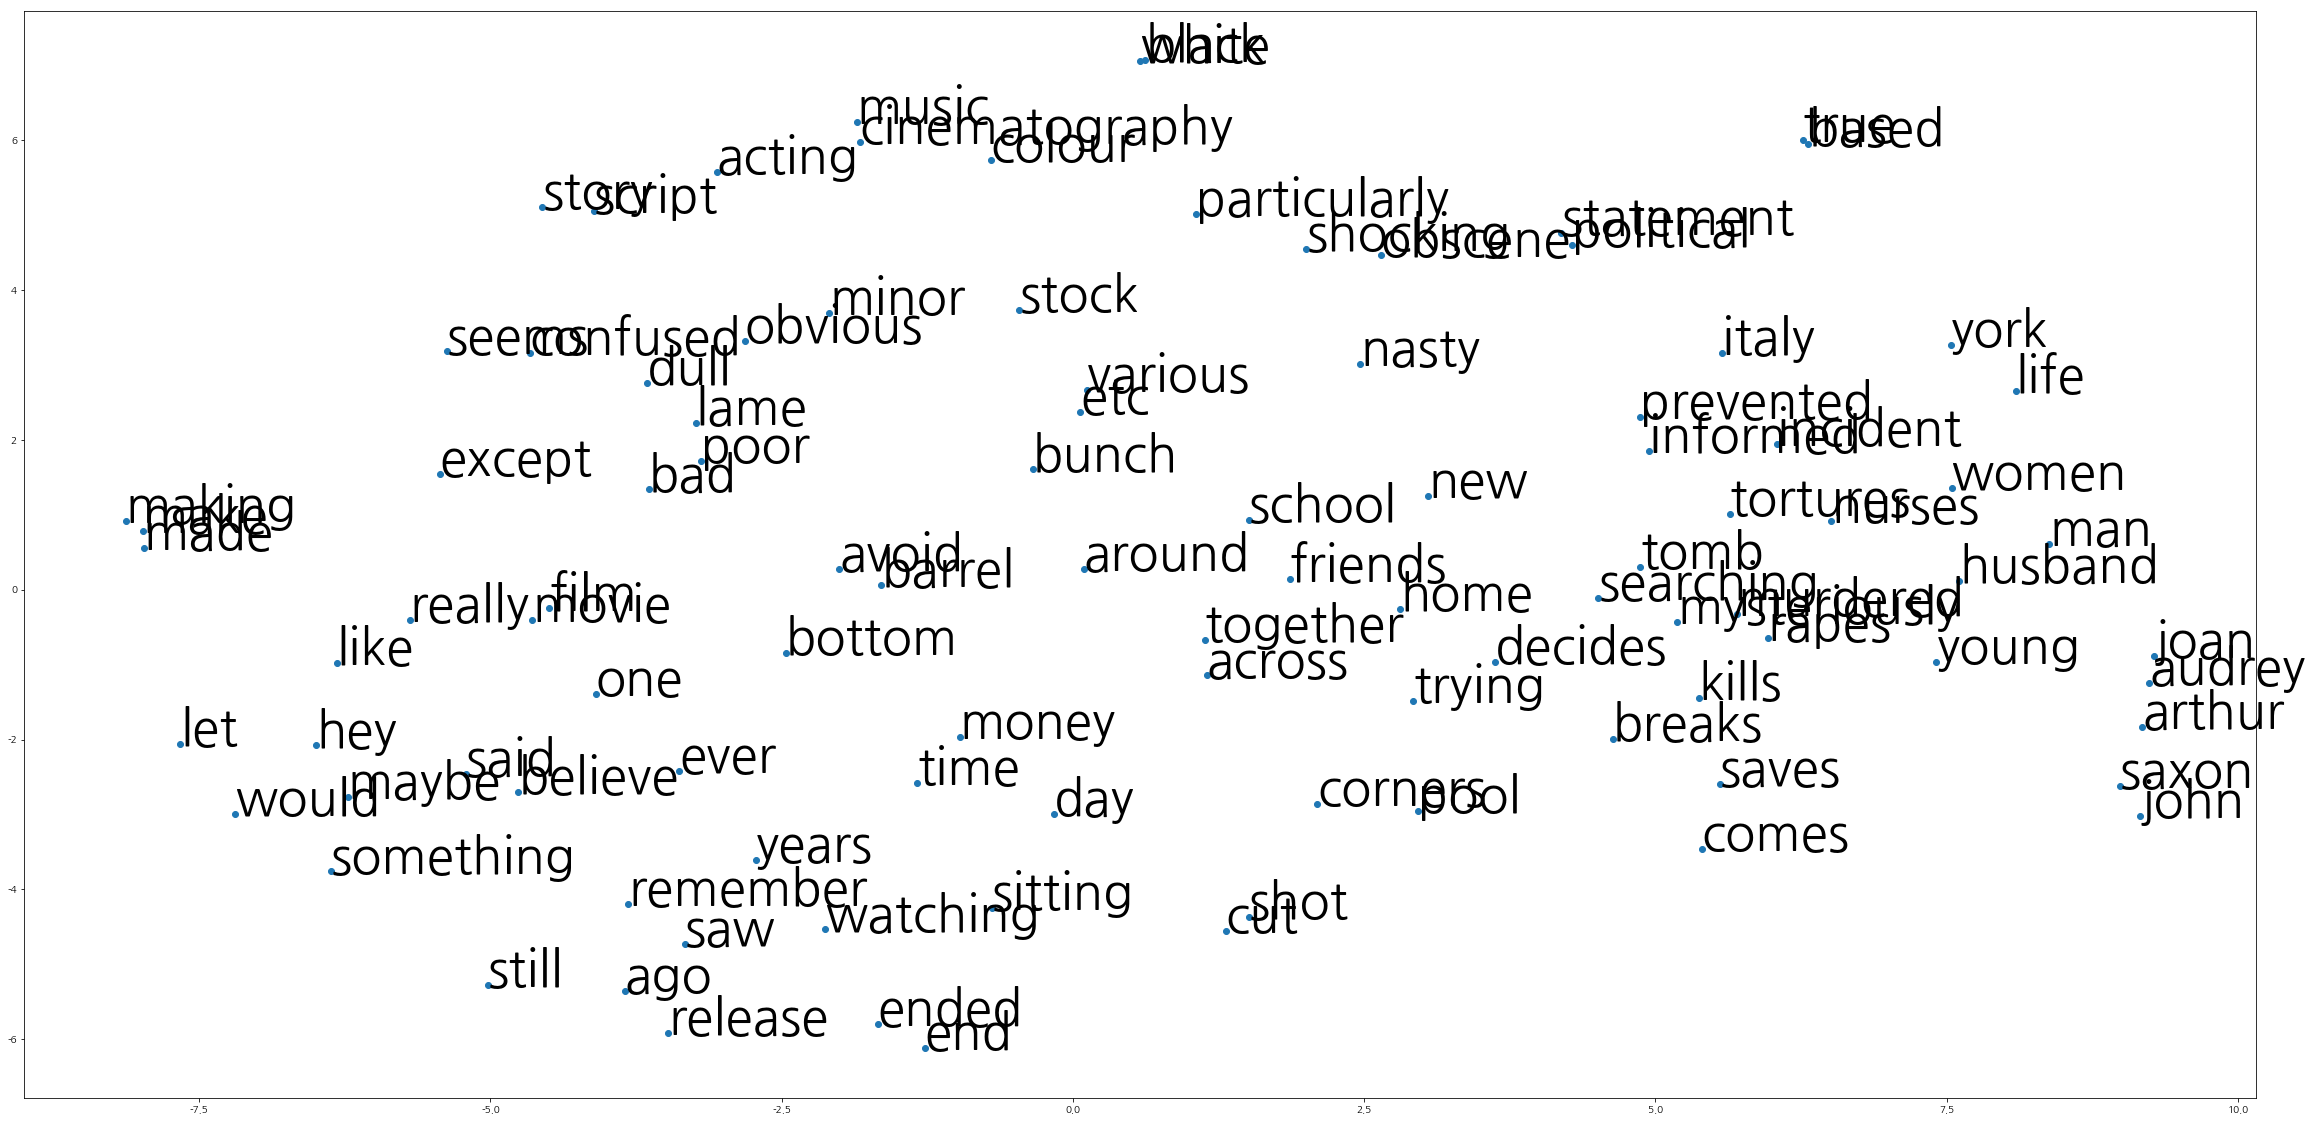

In [24]:
fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=50)
plt.show()